# Required Packages

#Imports

In [1]:
import awkward as ak
import torch
import torch_cluster
from torch_geometric.nn import knn_graph
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import Compose, RemoveIsolatedNodes, ToSparseTensor
from torch_geometric.data import Data, DataLoader
import networkx as nx
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats, scipy.optimize
import itertools
import matplotlib
from numba import jit
from numba.experimental import jitclass
from numba import float64
from numba.typed import List
try:
  import proposal as pp
except:
  print("Proposal not found - no realistic track simulation")
plt.rcParams['figure.dpi'] = 140

# Utillty Functions

## Physical Constants

In [2]:
# Pandel: https://www.sciencedirect.com/science/article/pii/S0927650507001260

class Constants(object):
  n_gr=1.35634
  n_ph=1.3195
  c_vac=2.99792458E8 *1E-9 # m/ns
  pandel_lambda = 33.3 # m
  pandel_rho = 0.004 # ns^-1
  lambda_abs = 98
  lambda_sca = 24
  theta_cherenkov = np.arccos(1/n_ph)
  # 1 GeV EM cascade corresponds to 5.3 m Cherenkov track length
  # In the relevent wavelength interval, a single charged particle emmits 250 photons / cm
  photons_per_GeV = 5.3 * 250 * 1E2
  photocathode_area = 500*1E-4 # m^2

## Detector Geometry and Sampling

In [3]:
class Module(object):
  def __init__(self, pos, noise_rate=1, efficiency=0.2):
    self.pos = pos
    self.noise_rate = noise_rate
    self.efficiency = efficiency

class Detector(object):
  def __init__(self, modules):
    self.modules = modules
    self.module_coords = np.vstack([m.pos for m in self.modules])
    self.module_coords_ak = ak.Array(self.module_coords)
    self.module_efficiencies = np.asarray([m.efficiency for  m in self.modules])
    
    self._outer_radius = np.linalg.norm(self.module_coords, axis=1).max()
    self._outer_cylinder = (np.linalg.norm(self.module_coords[:, :2], axis=1).max(),
                            2*np.abs(self.module_coords[:, 2].max()))
    self._n_modules = len(modules)

  @property
  def n_modules(self):
    return self._n_modules
    
  @property
  def outer_radius(self):
    return self._outer_radius

  @property
  def outer_cylinder(self):
    return self._outer_cylinder

def make_line(x, y, n_z, dist_z, rng, baseline_noise_rate):
    modules = []
    for pos_z in np.linspace(-dist_z * n_z / 2, dist_z*n_z / 2, n_z):
      pos = np.array([x, y, pos_z])
      noise_rate = scipy.stats.gamma.rvs(1, 0.25, random_state=rng) * baseline_noise_rate
      mod = Module(pos, noise_rate)
      modules.append(mod)
    return modules

def make_grid(
    n_side,
    dist,
    n_z,
    dist_z,
    baseline_noise_rate=1E-6,
    rng=np.random.RandomState(1337)):
  """
  Build a square detector grid.
  
  Strings of detector modules are placed on a square grid.
  The noise rate for each module is randomöy sampled from a gamma distribution
  
  Paramaters:
    n_side
      Number of detector strings per side
    dist
      Spacing between strings [m]
    n_z
      Number of detector modules per string
    dist_z
      Distance of modules on a string [m]
    baseline_noise_rate
      Baseline noise rate (default 1E-6Hz)
  """
  modules = []
  x_pos = np.linspace(-n_side/2 * dist, n_side/2 * dist, n_side)
  y_pos = x_pos

  for x, y in itertools.product(x_pos, y_pos):
    modules += make_line(x, y, n_z, dist_z, rng, baseline_noise_rate)

  return modules

def make_hex_grid(
    n_side,
    dist,
    n_z,
    dist_z,
    baseline_noise_rate=1E-6,
    rng=np.random.RandomState(1337)):
  """
  Build a hex detector grid.
  
  Strings of detector modules are placed on a square grid.
  The noise rate for each module is randomöy sampled from a gamma distribution
  
  Paramaters:
    n_side
      Number of detector strings per side
    dist
      Spacing between strings [m]
    n_z
      Number of detector modules per string
    dist_z
      Distance of modules on a string [m]
    baseline_noise_rate
      Baseline noise rate (default 1E-6Hz)
  """

  modules = []
  for irow in range(0, n_side-1):
    i_this_row = 2*(n_side-1) - irow
    x_pos = np.linspace(-i_this_row/2*dist, i_this_row/2*dist, i_this_row)
    y_pos = irow*dist 
    for x in x_pos:
      modules += make_line(x, y_pos, n_z, dist_z, rng, baseline_noise_rate)

    if irow != 0:
      x_pos = np.linspace(-i_this_row/2*dist, i_this_row/2*dist, i_this_row)
      y_pos = -irow*dist

      for x in x_pos:
        modules += make_line(x, y_pos, n_z, dist_z, rng, baseline_noise_rate)

  return modules


def sample_cylinder_surface(height, radius, n, rng=np.random.RandomState(1337)):
  """Sample points on a cylinder surface"""
  side_area = 2 * np.pi * radius * height
  top_area = 2 * np.pi * radius**2

  ratio = top_area / (top_area + side_area)

  is_top = rng.uniform(0, 1, size=n) < ratio
  n_is_top = is_top.sum()
  samples = np.empty((n, 3))
  theta = rng.uniform(0, 2*np.pi, size=n)
  
  # top / bottom points

  r = radius * np.sqrt(rng.uniform(0, 1, size=n_is_top))
  

  samples[is_top, 0] = r * np.sin(theta[is_top])
  samples[is_top, 1] = r * np.cos(theta[is_top])
  samples[is_top, 2] = rng.choice([-height / 2, height/2], replace=True, size=n_is_top)

  # side points

  r = radius
  samples[~is_top, 0] = r * np.sin(theta[~is_top])
  samples[~is_top, 1] = r * np.cos(theta[~is_top])
  samples[~is_top, 2] = rng.uniform(-height / 2, height/2, size=n-n_is_top)

  return samples
  
def sample_cylinder_volume(height, radius, n, rng=np.random.RandomState(1337)):
  """Sample points in cylinder volume"""
  theta = rng.uniform(0, 2*np.pi, size=n)
  r = radius * np.sqrt(rng.uniform(0, 1, size=n))
  samples = np.empty((n, 3))
  samples[:, 0] = r * np.sin(theta)
  samples[:, 1] = r * np.cos(theta)
  samples[:, 2] = rng.uniform(-height / 2, height/2, size=n)
  return samples

def sample_direction(n_samples, rng=np.random.RandomState(1337)):
  """Sample uniform directions"""

  cos_theta = rng.uniform(-1, 1, size=n_samples)
  theta = np.arccos(cos_theta)
  phi = rng.uniform(0, 2*np.pi)

  samples = np.empty((n_samples, 3))
  samples[:, 0] = np.sin(theta) * np.cos(phi)
  samples[:, 1] = np.sin(theta) * np.sin(phi)
  samples[:, 2] = np.cos(theta)
  
  return samples



def t_geo(x, t_0, direc, x_0):
  """
  Calculate the expected arrival time of unscattered photons at position `x`,
  emitted by a muon with direction `direc` and time `t_0` at position `x_0`.

  Parameters:
    x: (3,1) np.ndarray
      position of the sensor
    t_0: float
      time at which muon is at `x_0`
    direc: (3,1) np.ndarray
      normalized direction vector of the muon
    x_0: (3, 1) np.ndarray
  """
  q = np.linalg.norm(np.cross((x-x_0), direc))
  return t_0 + 1/Constants.c_vac * (np.dot(direc, (x - x_0)) + q * (Constants.n_gr*Constants.n_ph - 1) / np.sqrt((Constants.n_ph**2) - 1))


## Event Generation

### Utility

In [4]:
def proposal_setup():
  
  args = {
      "particle_def": pp.particle.MuMinusDef(),
      "target": pp.medium.Ice(),
      "interpolate": True,
      "cuts": pp.EnergyCutSettings(500, 1, False)
  }

  cross = pp.crosssection.make_std_crosssection(**args) # use the standard crosssections
  collection = pp.PropagationUtilityCollection()

  collection.displacement = pp.make_displacement(cross, True)
  collection.interaction = pp.make_interaction(cross, True)
  collection.time = pp.make_time(cross, args["particle_def"], True)

  utility = pp.PropagationUtility(collection = collection)

  detector = pp.geometry.Sphere(pp.Cartesian3D(0,0,0), 1e20)
  density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)
  prop = pp.Propagator(args["particle_def"], [(detector, utility, density_distr)])
  return prop

class MCRecord(object):
  def __init__(self, event_type, sources, mc_info):
    self.event_type = event_type
    self.sources = sources
    if not isinstance(mc_info, list):
      mc_info = [mc_info]
    self.mc_info = mc_info

  def __add__(self, other):
    if isinstance(other, MCRecord):
      new_ev_type = self.event_type + other.event_type
      new_src = self.sources + other.sources
      new_mcinfo = self.mc_info + other.mc_info
      return MCRecord(new_ev_type, new_src, new_mcinfo)

def generate_noise(det, time_range, rng=np.random.RandomState(1337)):
  """
  Generate detector noise in a time range
  """
  all_times_det = []
  dT = np.diff(time_range)
  for idom in range(len(det.modules)):
    noise_amp = rng.poisson(det.modules[idom].noise_rate * dT)
    times_det = rng.uniform(*time_range, size=noise_amp)
    all_times_det.append(times_det)
   
  return ak.sort(ak.Array(all_times_det))

def is_in_cylinder(radius, height, pos):
  return (np.sqrt(pos[0]**2 + pos[1]**2) < radius) & (np.abs(pos[2]) < height/2)

def track_isects_cyl(radius, height, pos, direc):
  """
  Check if a track intersects a cylinder
  """
  closest_appr = pos - (np.dot(pos, direc))*direc
  return is_in_cylinder(radius, height, closest_appr)


###Photon Propagation

In [5]:
@jitclass()
class PhotonSource(object):
  pos: float64[:]
  amp: float
  t0: float

  def __init__(self, pos, amp, t0):
    self.pos = pos
    self.amp = amp
    self.t0 = t0

@jit(nopython=True)
def generate_photons(
    module_coords,
    module_efficiencies,
    sources,
    c_vac=Constants.c_vac,
    n_gr=Constants.n_gr,
    pandel_lambda=Constants.pandel_lambda,
    theta_cherenkov=Constants.theta_cherenkov,
    pandel_rho=Constants.pandel_rho,
    photocathode_area=Constants.photocathode_area,
    lambda_abs=Constants.lambda_abs,
    lambda_sca = Constants.lambda_sca,
    seed=31337):
  """
  Generate photons for a list of sources

  The amplitude (== number of photon) at each detector module is modeled as exponential decay based on
  the distance to `pos` with decay constant `d0`. The detection process is modelled as poisson process.
  The photon arrival times are modeled using the 
  `Pandel`-PDF (https://www.sciencedirect.com/science/article/pii/S0927650507001260), which is a gamma distribution
  with distance-dependent scaling of the shape parameters.
  """
  all_times_det = []
  np.random.seed(seed)

  lambda_p = np.sqrt(lambda_abs * lambda_sca / 3)
  xi = np.exp(-lambda_sca / lambda_abs)
  lambda_c = lambda_sca / (3 * xi)

  for idom in range(module_coords.shape[0]):
    
    this_times = []
    total_length = 0
    for source in sources:
      dist = np.linalg.norm(source.pos-module_coords[idom])

      """
      # model photon emission as point-like

      detected_flux = source.amp * np.exp(-dist/d0) / (4*np.pi* dist**2)
      detected_photons = detected_flux * photocathode_area

      # from https://arxiv.org/pdf/1311.4767.pdf
      """
      detected_photons = (
          source.amp * photocathode_area / (4 * np.pi) *
          np.exp(-dist / lambda_p) *
          1 / (lambda_c * dist * np.tanh(dist / lambda_c))
      )
      
      amp_det = np.random.poisson(detected_photons * module_efficiencies[idom])

      time_geo = dist / (c_vac / n_gr) + source.t0
      pandel_xi = dist / (pandel_lambda * np.sin(theta_cherenkov)) 
      
      times_det = np.random.gamma(pandel_xi, scale=1/pandel_rho,
                            size=amp_det) + time_geo
      this_times.append(times_det)
      total_length += amp_det
    
    this_times_arr = np.empty(total_length)
    i = 0
    for tt in this_times:
      this_times_arr[i:i+tt.shape[0]] = tt
      i += tt.shape[0]

    all_times_det.append(this_times_arr)

  return all_times_det


###Cascade Generation

In [6]:
def generate_cascade(det, pos, t0, energy, d0=33, seed=31337):
  """
  Generate a single cascade (point-like light source) with given amplitude and position and return time of
  detected photons.
  
  Parameters:
    det: Detector
      Instance of Detector class
    pos: np.ndarray
      Position (x, y, z) of the cascade
    t0: float
      Time of the cascade
    energy: float
      Energy of the cascade
    d0: Decay constant for photon absorption [m]
    seed: int
  """
  
  source = PhotonSource(pos, energy*Constants.photons_per_GeV, t0)
  source_list = [source]
  record = MCRecord(
      "cascade",
      source_list,
      {"energy": energy, "position": pos})
  hit_times = ak.sort(
      ak.Array(
          generate_photons(det.module_coords, det.module_efficiencies, List(source_list), seed=seed)))
  return hit_times, record

def generate_cascades(
    det,
    height,
    radius,
    nsamples,
    d0=33,
    seed=31337,
    ):
  """
  Generate a sample of cascades, randomly sampling the positions in a cylinder of given radius and length.
  """
  rng = np.random.RandomState(seed)
  positions = sample_cylinder_volume(height, radius, nsamples, rng)
  # Sample energy uniform in log
  energies = np.power(10, rng.uniform(2, 5, size=nsamples))

  events = []
  records = []
  for i, (pos, energy) in enumerate(zip(positions, energies)):
    event, record = generate_cascade(det, pos, 0, energy, d0, seed+i)
    if ak.count(event) == 0:
      continue
    time_range = [ak.min(ak.flatten(event)) - 1000, ak.max(ak.flatten(event)) + 5000]
    noise = generate_noise(det, time_range)
    event = ak.sort(ak.concatenate([event, noise], axis=1))
    events.append(event)
    records.append(record)
  return events, records


###Track Generation

In [7]:
def generate_realistic_track(
    det,
    pos,
    direc,
    track_len,
    energy,
    t0=0,
    res=10,
    seed=31337,
    rng=np.random.RandomState(31337),
    propagator=None):
  
  """
  Generate a realistic track approximated by cascades at intervals with exponentially
  distributed distances.

  Parameters:
    det: Detector
      Instance of Detector class
    pos: np.ndarray
      Position (x, y, z) of the track at t0
    direc: np.ndarray
      Direction (dx, dy, dz) of the track
    track_len: float
      Length of the track
    energy: float
      Initial energy of the track   
    t0: float
      Time at position `pos`
    seed: int
    rng: RandomState
    propagator: Proposal propagator
  """

  sources = []
  
  if propagator is None:
    raise RuntimeError()

  init_state = pp.particle.ParticleState()
  init_state.energy = energy*1E3 # initial energy in MeV
  init_state.position = pp.Cartesian3D(0, 0, 0)
  init_state.direction = pp.Cartesian3D(0, 0, 1)
  track = propagator.propagate(init_state, track_len*100) # cm

  # harvest losses
  for loss in track.stochastic_losses():
    dist = loss.position.z / 100
    e_loss = loss.energy / 1E3
    p = pos + dist*direc
    t = dist / Constants.c_vac + t0

    if np.linalg.norm(p) > det.outer_radius + 3 * Constants.lambda_abs:
      continue
    sources.append(PhotonSource(p, e_loss * Constants.photons_per_GeV, t))
  
  if not sources:
    return None

  record = MCRecord(
      "realistic_track",
      sources,
      {"position": pos, "energy": energy, "track_len": track.track_propagated_distances()[-1]/100, "direction": direc})
  hit_times = ak.sort(
      ak.Array(
          generate_photons(det.module_coords, det.module_efficiencies, List(sources), seed=seed)))
  return hit_times, record

def generate_realistic_tracks(
    det,
    height,
    radius,
    nsamples,
    seed=31337,
    propagator=None,
    ):
  rng = np.random.RandomState(seed)
  # Safe length to that tracks will appear infinite
  # TODO: Calculate intersection with generation cylinder
  track_length = 3000
  
  positions = sample_cylinder_surface(height, radius, nsamples, rng)
  directions = sample_direction(nsamples, rng)

  # Sample energy uniform in log
  tot_energies = np.power(10, rng.uniform(2, 6, size=nsamples))

  events = []
  records = []

  for i, (pos, energy, direc) in enumerate(zip(positions, tot_energies, directions)):

    # shift pos back by half the length:
    pos = pos - track_length/2 * direc

    result = generate_realistic_track(
        det,
        pos,
        direc,
        track_length,
        energy=energy,
        t0=0,
        seed=seed+i,
        rng=rng,
        propagator=propagator,
        )
    if result is None:
      continue
    event, record = result
    if ak.count(event) == 0:
      continue
    time_range = [ak.min(ak.flatten(event)) - 1000, ak.max(ak.flatten(event)) + 5000]
    noise = generate_noise(det, time_range)
    event = ak.sort(ak.concatenate([event, noise], axis=1))
    events.append(event)
    records.append(record)
  return events, records


def generate_realistic_starting_tracks(
    det,
    height,
    radius,
    nsamples,
    seed=31337,
    propagator=None,
    ):
  rng = np.random.RandomState(seed)
  # Safe length to that tracks will appear infinite
  # TODO: Calculate intersection with generation cylinder
  track_length = 3000
  
  positions = sample_cylinder_volume(height, radius, nsamples, rng)
  directions = sample_direction(nsamples, rng)

  # Sample energy uniform in log
  tot_energies = np.power(10, rng.uniform(2, 6, size=nsamples))

  # TODO: Realistic inelasticity
  inelasticities = np.power(10, rng.uniform(-3, 0, size=nsamples))


  events = []
  records = []

  for i, (pos, energy, direc, inelas) in enumerate(zip(positions, tot_energies, directions, inelasticities)):

    result = generate_realistic_track(
        det,
        pos,
        direc,
        track_length,
        energy=energy * inelas,
        t0=0,
        seed=seed+i,
        rng=rng,
        propagator=propagator,
        )
    if result is None:
      continue
    event, record = result

    # Generate the initial cascade
    event_c, record_c = generate_cascade(det, pos, 0, energy * (1-inelas), seed=seed+i)
    event = ak.concatenate([event, event_c], axis=1)
    record = record+record_c
    if ak.count(event) == 0:
      continue


    time_range = [ak.min(ak.flatten(event)) - 1000, ak.max(ak.flatten(event)) + 5000]
    noise = generate_noise(det, time_range)
    event = ak.sort(ak.concatenate([event, noise], axis=1))
    events.append(event)
    records.append(record)
  return events, records


def generate_uniform_track(
    det,
    pos,
    direc,
    track_len,
    energy,
    t0=0,
    res=10,
    seed=31337):
  """
  Generate a track approximated by cascades at fixed intervals.

  Parameters:
    det: Detector
      Instance of Detector class
    pos: np.ndarray
      Position (x, y, z) of the track at t0
    direc: np.ndarray
      Direction (dx, dy, dz) of the track
    track_len: float
      Length of the track
    energy: float
      Energy of each individual cascade
    t0: float
      Time at position `pos`
    res: float
      Distance of cascades along the track [m]
    seed: float

  """
  sources = []
  
  for i in np.arange(0, track_len, res):
    p = pos + i*direc

    # Check if this position is way outside of the detector.
    # In that case: ignore

    if np.linalg.norm(p) > det.outer_radius + 3 * Constants.lambda_abs:
      continue

    t = i / Constants.c_vac + t0
    sources.append(PhotonSource(p, energy * Constants.photons_per_GeV, t))

  record = MCRecord(
      "uniform_track",
      sources,
      {"position": pos, "energy": energy, "track_len": track_len, "direction": direc})
  hit_times = ak.sort(
      ak.Array(
          generate_photons(det.module_coords, det.module_efficiencies, List(sources), seed=seed)))
  return hit_times, record

def generate_uniform_tracks(
    det,
    height,
    radius,
    nsamples,
    seed=31337,
    ):
  rng = np.random.RandomState(seed)
  # Safe length to that tracks will appear infinite
  # TODO: Calculate intersection with generation cylinder
  track_length = 3000
  
  positions = sample_cylinder_surface(height, radius, nsamples, rng)
  directions = sample_direction(nsamples, rng)


  # Sample amplitude uniform in log
  amplitudes = np.power(10, rng.uniform(0, 4, size=nsamples))

  events = []
  records = []

  for i, (pos, amp, direc) in enumerate(zip(positions, amplitudes, directions)):

    # shift pos back by half the length:
    pos = pos - track_length/2 * direc

    event, record = generate_uniform_track(det, pos, direc, track_length, amp, 0, 10, seed+i)
    if ak.count(event) == 0:
      continue
    time_range = [ak.min(ak.flatten(event)) - 1000, ak.max(ak.flatten(event)) + 5000]
    noise = generate_noise(det, time_range)
    event = ak.sort(ak.concatenate([event, noise], axis=1))
    events.append(event)
    records.append(record)
  return events, records


## Traditional Reconstructions [WIP]

In [8]:
def linefit2(det, hit_times):
  t_first = ak.firsts(hit_times)
  positions = det.module_coords_ak
  hit = ~ak.is_none(t_first)

  def loss(pars):
    d_hyp = pars[:3]
    d_hyp /= np.linalg.norm(d_hyp)
    x0_hyp = pars[3:]

    x_hypo = t_first * d_hyp * Constants.c_vac + x0_hyp
    chi2 = ak.sum((x_hypo - positions)**2)
    return -chi2

  return scipy.optimize.fmin_l_bfgs_b(loss, [0., 0., 0., 1., 0., 0.])


def linefit(det, hit_times):
  t_first = ak.firsts(hit_times)
  positions = det.module_coords_ak
  hit = ~ak.is_none(t_first)
  
  mean_pos = ak.mean(positions[hit], axis=0)
  mean_time = ak.mean(t_first[hit])

  v = (
      (ak.mean(positions[hit]  * t_first[hit][:, None], axis=0)
       - mean_pos * mean_time)
      / (ak.mean(t_first[hit]**2) - mean_time**2)
  )

  r = mean_pos - v * mean_time

  return r, v

## Feature Generation and Utilities

In [9]:
def get_features(hit_times, reference="median_global"):

  if reference == "median_global":

    sorted_times = np.sort(ak.flatten(hit_times).to_numpy())
    reference = sorted_times[int(0.5*sorted_times.shape[0])]

  else:
    raise NotImplementedError()

  n_total = len(hit_times)
  hits = ak.count(hit_times, axis=1) > 0
  hit_times = hit_times[hits]
  hits = hits.to_numpy()


  percentiles = np.linspace(0.1, 0.9, num=9)
  features = np.empty((n_total, len(percentiles)+6))
  #mean = ak.mean(hit_times, axis=1) - reference

  p_values = []
  for i, p in enumerate(percentiles):
    features[hits, i] = (ak.flatten(
      hit_times[ak.from_regular(ak.values_astype(ak.count(hit_times, axis=1) / (1/p), np.int64)[:, None], 1)],
      axis=1) - reference) / 1E3

  features[hits, len(percentiles)] = (ak.firsts(hit_times) - reference) / 1E3
  features[hits, len(percentiles)+1] = np.log10(ak.count(hit_times, axis=1))
  features[hits, len(percentiles)+2] = (ak.std(hit_times, axis=1)) / 1E3
  features[hits, len(percentiles)+3] = det.module_coords_ak[hits, 0] / 100
  features[hits, len(percentiles)+4] = det.module_coords_ak[hits, 1] / 100
  features[hits, len(percentiles)+5] = det.module_coords_ak[hits, 2] / 100
 
  features[~hits, :] = np.nan


  """
  hits = hits.to_numpy()
  features[hits, 0] = mean / 1E3
  features[hits, 1] = median / 1E3
  features[hits, 2] = first / 1E3
  features[hits, 3] = std / 1E3
  features[hits, 4] = p10 / 1E3
  features[hits, 5] = np.log10(total)
  features[hits, 6] = det.module_coords_ak[hits, 0] / 100
  features[hits, 7] = det.module_coords_ak[hits, 1] / 100
  features[hits, 8] = det.module_coords_ak[hits, 2] / 100
  features[~hits, :] = np.nan
  """
  

  return features


## Plotting

In [10]:
def plot_event(det, hit_times, record=None, plot_tfirst=False):
  fig = plt.figure()

  if plot_tfirst:
    plot_target = ak.fill_none(ak.firsts(hit_times, axis=1), np.nan)
  else:
    plot_target = ak.count(hit_times, axis=1)

  ax = fig.add_subplot(projection='3d')
  ax.scatter(det.module_coords[:, 0], det.module_coords[:, 1], det.module_coords[:, 2], c=plot_target,
            cmap=plt.cm.viridis,
            norm=matplotlib.colors.LogNorm())
  if record is not None:
    for source in record.sources:
      ms = (np.log10(source.amp) / 2)**2
      ax.plot([source.pos[0]], [source.pos[1]], [source.pos[2]], "ok", markersize=ms)
  
  return ax

def plot_events(det, events, labels=None, records=None, plot_tfirst=False):
  nplt = int(np.ceil(np.sqrt(len(events))))
  fig = plt.figure(figsize=(nplt*4, nplt*4))

  for i, hit_times in enumerate(events):
    if plot_tfirst:
      plot_target = ak.fill_none(ak.firsts(hit_times, axis=1), np.nan)
    else:
      plot_target = ak.count(hit_times, axis=1)
    ax = fig.add_subplot(nplt, nplt, i+1, projection='3d')
    """
    ax.scatter(det.module_coords[:, 0], det.module_coords[:, 1], det.module_coords[:, 2], c="k",
              alpha=0.05,
               ms=5)
    """
    ax.scatter(det.module_coords[:, 0], det.module_coords[:, 1], det.module_coords[:, 2], c=plot_target,
              cmap=plt.cm.viridis,
              norm=matplotlib.colors.LogNorm(),
              )
    
              
    if labels is not None:
      ax.set_title(labels[i], fontsize="small")
    if records is not None:
      record = records[i]
      for source in record.sources:
        ms = (np.log10(source.amp) / 2)**2
        ax.plot([source.pos[0]], [source.pos[1]], [source.pos[2]], "ok", markersize=ms)
    ax.set_xlim3d(-700, 700)
    ax.set_ylim3d(-700, 700)
    ax.set_zlim3d(-500, 500)
  
  return fig



# Examples

### Sample points in cylinder volume

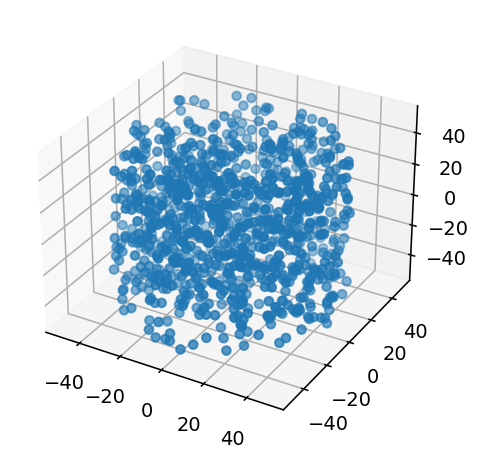

In [11]:
samples = sample_cylinder_volume(100, 50, 1000)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])

### Sample points on cylinder surface

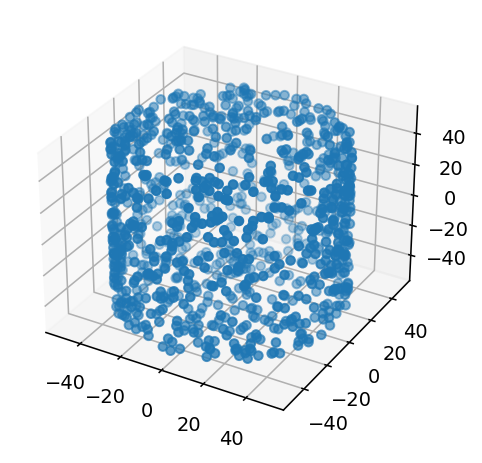

In [12]:
samples = sample_cylinder_surface(100, 50, 1000)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])

### Construct a Detector

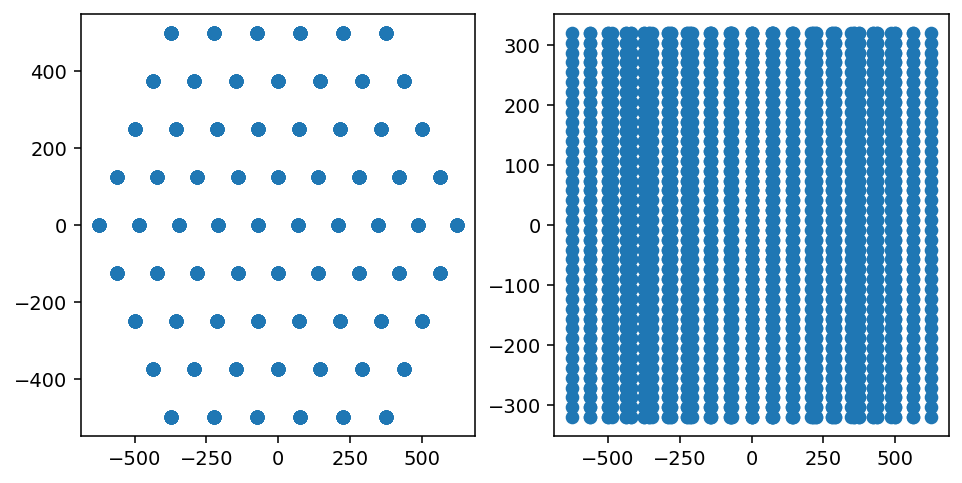

In [13]:
modules = make_hex_grid(6, 125, 40, 16)

det = Detector(modules)
#print(det.module_coords)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(det.module_coords[:, 0], det.module_coords[:, 1], "o")
axs[1].plot(det.module_coords[:, 0], det.module_coords[:, 2], "o")

### Simulate a Cascade Event

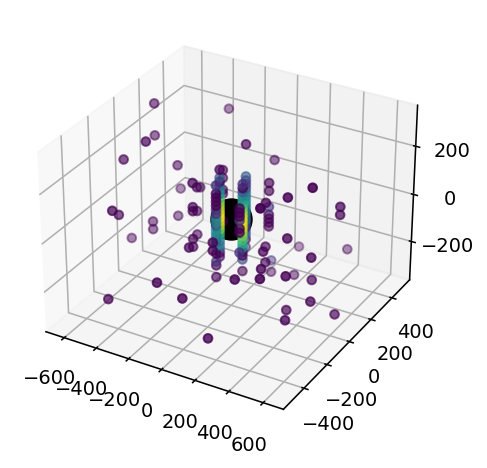

In [14]:
pos = np.array([0., 0., 0.])
event_times, record = generate_cascade(det, pos, t0=0, energy=1E4)
time_range = [ak.min(ak.flatten(event_times)) - 1000, ak.max(ak.flatten(event_times)) + 5000]
noise = generate_noise(det, time_range)
event_times = ak.concatenate([event_times, noise], axis=1)
plot_event(det, event_times, record);

Now plot the arrival time distribution at the detector module with the largest amplitude.

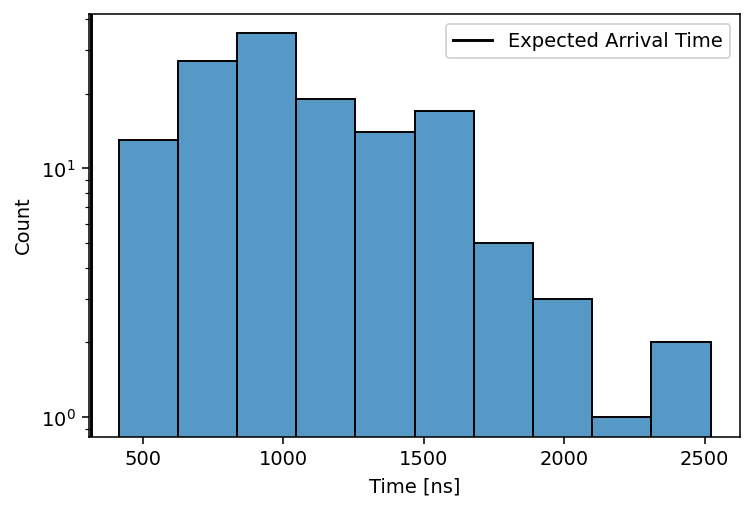

In [15]:
max_amp = ak.argmax(ak.count(event_times, axis=1))
times = event_times[max_amp]

sns.histplot(times.to_numpy())
plt.semilogy()
plt.xlabel("Time [ns]")

# Calculate expected arrival time (time of an unscattered photon)
dist = np.linalg.norm(pos - det.module_coords[max_amp])
dT = dist / (Constants.c_vac / Constants.n_gr)

plt.axvline(dT, color="k", label="Expected Arrival Time")
plt.legend()


### Simulate a Track Event

'\nr, v = linefit(det, event_times)\nv = v / np.sqrt(ak.sum(v**2))\n\np0 = r - 200*v\np1 = r + 200*v\n\nax.plot([p0[0], p1[0]],\n        [p0[1], p1[1]],\n        [p0[2], p1[2]],\n        )\nax.quiver(\n        pos[0], pos[1], pos[2], # <-- starting point of vector\n        direc[0], direc[1], direc[2],# <-- directions of vector\n        color = \'red\', alpha = .8, lw = 3,\n        length=200,\n        arrow_length_ratio=0.1\n    )\n\nax.plot([det.module_coords[138][0]],\n        [det.module_coords[138][1]],\n        [det.module_coords[138][2]],\n        "ok"\n        )\n'

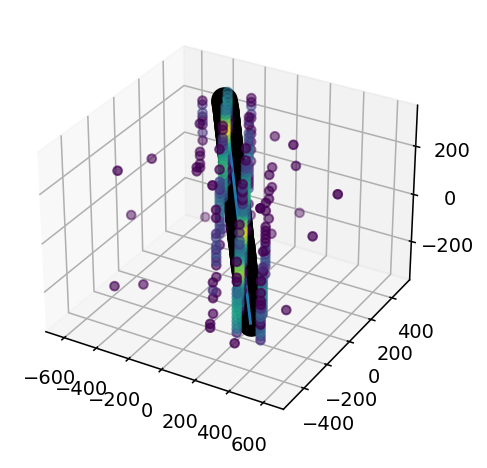

In [ ]:
pos = np.array([0., 50, 20.])
direc = np.asarray([-1., 1., 1])
direc /= np.linalg.norm(direc)
length = 1000
pos -= length/2 * direc

event_times,  record = generate_uniform_track(det, pos, direc, length, 1E2)
time_range = [ak.min(ak.flatten(event_times)) - 1000, ak.max(ak.flatten(event_times)) + 1000]
noise = generate_noise(det, time_range)
event_times = ak.concatenate([event_times, noise], axis=1)

ax = plot_event(det, event_times, record)

pos1 = pos + length*direc
ax.plot([pos[0], pos1[0]],
        [pos[1], pos1[1]],
        [pos[2], pos1[2]],
        )

"""
r, v = linefit(det, event_times)
v = v / np.sqrt(ak.sum(v**2))

p0 = r - 200*v
p1 = r + 200*v

ax.plot([p0[0], p1[0]],
        [p0[1], p1[1]],
        [p0[2], p1[2]],
        )
ax.quiver(
        pos[0], pos[1], pos[2], # <-- starting point of vector
        direc[0], direc[1], direc[2],# <-- directions of vector
        color = 'red', alpha = .8, lw = 3,
        length=200,
        arrow_length_ratio=0.1
    )

ax.plot([det.module_coords[138][0]],
        [det.module_coords[138][1]],
        [det.module_coords[138][2]],
        "ok"
        )
"""

### Simulate a Realistic Muon

In [ ]:
pos = np.array([0., 50, 20.])
direc = np.asarray([-1., 1., 1])
direc /= np.linalg.norm(direc)
length = 1000
pos -= length/2 * direc

rng = np.random.RandomState(31337)

# get a proposal propagator
prop = proposal_setup()

event_times, record = generate_realistic_track(
    det,
    pos,
    direc,
    length,
    energy=1E5,
    t0=0,
    rng=rng,
    propagator=prop)
time_range = [ak.min(ak.flatten(event_times)) - 1000, ak.max(ak.flatten(event_times)) + 1000]
noise = generate_noise(det, time_range)
event_times = ak.concatenate([event_times, noise], axis=1)

ax = plot_event(det, event_times, record)

pos1 = pos + length*direc
ax.plot([pos[0], pos1[0]],
        [pos[1], pos1[1]],
        [pos[2], pos1[2]],
        )




### Simulate Two Cascades

In [ ]:
pos = np.array([0., -200., 0.])
event_times, record = generate_cascade(det, pos, t0=0, energy=1E4)

pos = np.array([0., 200., 0.])
event_times2, record2 = generate_cascade(det, pos, t0=0, energy=1E5)
event_times = ak.concatenate([event_times, event_times2], axis=1)
record = record + record2

plot_event(det, event_times, record);


In [ ]:
max_amp = ak.argmax(ak.count(event_times, axis=1))
times = event_times[max_amp]

sns.histplot(times.to_numpy())
plt.semilogy()
plt.xlabel("Time [ns]")

# Calculate expected arrival time (time of an unscattered photon)
dist = np.linalg.norm(pos - det.module_coords[max_amp])
dT = dist / (Constants.c_vac / Constants.n_gr)

plt.axvline(dT, color="k", label="Expected Arrival Time")
plt.legend()


Plot distribution of features

In [ ]:
feature_names = ["p{:.2f}".format(p*100) for p in np.linspace(0.1, 0.9, num=9)]
feature_names += ["time of first hit", "log10(amplitude)", "standard dev.", "module x", "module y", "module z"]

# Use all features for kNN
features = get_features(event_times)
valid = np.all(np.isfinite(features), axis=1)
features = features[valid]
fdict = {feature_names[i]: features[:, i] for i in range(features.shape[1])}
sns.histplot(fdict)



Now convert event into a graph using kNN

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Use all features for kNN
features = get_features(event_times)
valid = np.all(np.isfinite(features), axis=1)
features = features[valid]
x = torch.Tensor(features)
edge_index = knn_graph(x, k=5, loop=False)
data = RemoveIsolatedNodes()(torch_geometric.data.Data(x, edge_index))
G = to_networkx(data, to_undirected=True)
plt.figure()
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                  #node_color=det.module_coords[:, 2],
                  cmap="viridis", node_size=10, ax=axs[0])

# Use only positions and tfirst for kNN
features = get_features(event_times)
valid = np.all(np.isfinite(features), axis=1)
features = features[valid][:, [2, 6, 7, 8]]
x = torch.Tensor(features)
edge_index = knn_graph(x, k=5, loop=False)

data = RemoveIsolatedNodes()(torch_geometric.data.Data(x, edge_index))
G = to_networkx(data, to_undirected=True)
plt.figure()
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                  #node_color=det.module_coords[:, 2],
                  cmap="viridis", node_size=10, ax=axs[1])


### Plot Graph for a Track

In [ ]:
pos = np.array([0., 50, 20.])
direc = np.asarray([-1., 1., 1])
direc /= np.linalg.norm(direc)

length = 1000

pos -= length/2 * direc

event_times, record = generate_uniform_track(det, pos, direc, length, 1E5)
features = get_features(event_times)
valid = np.all(np.isfinite(features), axis=1)
features = features[valid]
x = torch.Tensor(features)
edge_index = knn_graph(x, k=5, loop=False)

data = RemoveIsolatedNodes()(torch_geometric.data.Data(x, edge_index))
G = to_networkx(data, to_undirected=True)
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                  #node_color=det.module_coords[:, 2],
                  cmap="viridis", node_size=10)

# GNN for Classification

## Generate Training Data

In [ ]:
seed = 31337
modules = make_hex_grid(6, 125, 40, 16)
det = Detector(modules)
prop = proposal_setup()
cascades, cascade_records = generate_cascades(det, 900, 750, 2000, seed=seed)
tracks, track_records = generate_realistic_tracks(det, 900, 750, 2000, seed=seed, propagator=prop)
stracks, strack_records = generate_realistic_starting_tracks(det, 900, 750, 2000, seed=seed, propagator=prop)


In [ ]:
det_hull = det.outer_cylinder
labels = []
for r in cascade_records:
  if is_in_cylinder(det_hull[0], det_hull[1], r.mc_info[0]["position"]):
    labels.append(0) # contained cascade
  else:
    labels.append(1) # uncontained cascade

for r in track_records:
  if track_isects_cyl(det_hull[0], det_hull[1], r.mc_info[0]["position"], r.mc_info[0]["direction"]):
    labels.append(2) # throughgoing track
  else:
    labels.append(3) # skimming track

for r in strack_records:
  if is_in_cylinder(det_hull[0], det_hull[1], r.mc_info[0]["position"]):
    labels.append(4) # starts in detector
  else:
    labels.append(5) # starts outside

Plot some events. Here we plot the arrival time of the first photon instead of the photon count.

In [ ]:
plot_events(det, cascades[:5]+ tracks[:5] + stracks[:5], None, cascade_records[:5]+track_records[:5]+strack_records[:5], plot_tfirst=True);

Plot amplitude instead

In [ ]:
plot_events(det, cascades[:5]+ tracks[:5] + stracks[:5], None, cascade_records[:5]+track_records[:5]+strack_records[:5], plot_tfirst=False);

In [ ]:
import random
data_array = []
all_events = cascades+tracks+stracks

transf = Compose([RemoveIsolatedNodes(), ToSparseTensor()])


for event, label in zip(all_events, labels):
  features = get_features(event)
  valid = np.all(np.isfinite(features), axis=1)

  features = features[valid]
  x = torch.Tensor(features)
  edge_index = knn_graph(x, k=5, loop=False)
  data = transf(torch_geometric.data.Data(x, edge_index, y=torch.tensor([label], dtype=torch.int64)))
  data_array.append(data)

indices = np.arange(len(data_array))
random.shuffle(indices)

shuffled_data = [data_array[i] for i in indices]

split = 3000

train_dataset = shuffled_data[:split]
test_dataset = shuffled_data[split:]
test_indices = indices[split:]

torch.manual_seed(31337)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



## Construct GNN

In [ ]:
from torch.nn import Linear, Softmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, TAGConv
from torch_geometric.nn import global_mean_pool, global_max_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features=9, num_classes=2):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, 2*hidden_channels)
        self.conv3 = GraphConv(2*hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)
        self.softmax = Softmax()

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.softmax(x)
        
        return x

class GCNTAG(torch.nn.Module):
  def __init__(self, hidden_channels, hidden_channels_lin, num_node_features=9, num_classes=2):
      super(GCNTAG, self).__init__()
      torch.manual_seed(12345)
      self.conv1 = TAGConv(num_node_features, hidden_channels)
      self.conv2 = TAGConv(hidden_channels, hidden_channels)
      self.conv3 = TAGConv(hidden_channels, hidden_channels)
      self.lin = Linear(2*hidden_channels, hidden_channels_lin)
      self.lin2 = Linear(hidden_channels_lin, num_classes)

  def forward(self, x, adj_t, batch):
      # 1. Obtain node embeddings

      x = self.conv1(x, adj_t)
      x = x.relu()
      x = self.conv2(x, adj_t)
      x = x.relu()
      x = self.conv3(x, adj_t)

      # 2. Readout layer
      x1 = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
      x2 = global_max_pool(x, batch)
      x = torch.cat([x1, x2], axis=1)

      # 3. Apply a final classifier
      x = F.dropout(x, p=0.5, training=self.training)
      x = self.lin(x)
      x = x.relu()
      x = self.lin2(x)
      x = x.relu()
      
      return x

## Train GNN

In [ ]:
model = GCNTAG(hidden_channels=32, hidden_channels_lin=100, num_node_features=15, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.adj_t, data.batch)  # Perform a single forward pass.
         #loss = criterion(out, data.y)  # Compute the loss.
         loss = criterion(out, data.y % 2)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.adj_t, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         #correct += int((pred == data.y).sum())  # Check against ground-truth labels.
         correct += int((pred == (data.y % 2)).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 20):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 10 == 0:
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')




Extract true / predicted labels for the testing set

In [ ]:
preds = []
truths = []
scores = []

with torch.no_grad():

  for data in test_loader:  # Iterate in batches over the training/test dataset.
    out = model(data.x, data.adj_t, data.batch)
    pred = out.argmax(dim=1) 
    preds.append(pred)
    truths.append(data.y % 2)
    scores.append(out)

  preds = torch.cat(preds)
  truths = torch.cat(truths)
  scores = torch.cat(scores)


Plot misclassified events

In [ ]:
"""
label_map = {
    0: "Contained Cascade",
    1: "Uncontained Cascade",
    2: "Throughgoing Track",
    3: "Skimming Track",
    4: "Starting Track",
    5: "Track starts outside"}
"""
label_map = {
    0: "Contained",
    1: "Uncontained",
    }
misscls_i = np.atleast_1d(test_indices[np.argwhere(preds != truths).ravel()])
corrcls_i = np.atleast_1d(test_indices[np.argwhere(preds == truths).ravel()])
misscls = [all_events[i] for i in misscls_i]
all_records = cascade_records + track_records + strack_records
misscls_records = [all_records[i] for i in misscls_i]
misscls_pred = preds[np.argwhere(preds != truths).ravel()].numpy()

plot_labels = [f"Truth: {label_map[labels[i] %2]} \n Predicted: {label_map[pred]}" for i, pred in zip(misscls_i, misscls_pred)]

plot_events(det, misscls[:9], plot_labels[:9], misscls_records[:9]);

In [ ]:
all_preds = []
score_for_true = []



for i in range(6):
  true_sel = truths == i
  #score_cut = 1 # scores[:, i] > 0.2
  #print("Surviving: ", score_cut.sum() / score_cut.shape[0])

  predictions = np.histogram(preds[true_sel], bins=np.arange(0, 7, 1))[0]
  predictions = predictions / predictions.sum()
  all_preds.append(predictions)
all_preds = np.vstack(all_preds)

  


In [ ]:
xticklabels=list(label_map.keys())

In [ ]:
xticklabels

In [ ]:
sns.heatmap(all_preds, cmap=plt.cm.Blues, annot=True, xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

In [ ]:

track_energies = []

for miscls_start in np.argwhere(labels_arr[misscls_i] == 2).ravel():
  inelas = misscls_records[miscls_start]
  track_energies.append(inelas.mc_info[0]["energy"])

track_energies_corr = []
for i in corrcls_i:
  if all_records[i].event_type == "realistic_trackcascade":
    inelas = all_records[i]
  track_energies_corr.append(inelas.mc_info[0]["energy"])


sns.histplot({"mis": np.log10(track_energies), "cor": np.log10(track_energies_corr)}, stat="probability")





In [ ]:
misscls_records[2].event_type